In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import SGD ,AdamW

from datasets import load_dataset, load_metric

import matplotlib.pyplot as plt

import json


In [2]:
import utils_generic as generic
import multitask_dep as mt
import model_confs as confs
import train_dep as train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)
tasks = ['to','as','about']

In [4]:
model_conf = confs.distilbert_conf
encoding_type = 'pos'

# Datos ConvAI

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = mt.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [8]:
convai_train_dataset = mt.DatasetMultitaskDep(convai_train_token,tasks,eval=False)
convai_val_dataset = mt.DatasetMultitaskDep(convai_val_token,tasks,eval=False)

# Datos md_gender

In [9]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [10]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 
md_dataset = mt.DatasetMultitaskDep(md_tokenized,tasks,eval=True)

# Creación dataloaders

In [11]:
dl_train =DataLoader(convai_train_dataset,batch_size=128,shuffle=True,collate_fn=mt.collate_fn)
dl_val =DataLoader(convai_val_dataset,batch_size=128,shuffle=True,collate_fn=mt.collate_fn)
dl_eval = DataLoader(md_dataset,batch_size=128,shuffle=False,collate_fn=mt.collate_fn)

# Modelo multitask

In [12]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
save_path='m1_distilbert_multi_pos'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
print("Accuracy evaluando en todas las etiquetas")
print(train.eval_function_multi(model,dl_eval,tasks))
print("Accuracy evaluando en etiquetas female")
print(train.eval_function_multi(model,dl_eval,tasks,'female'))
print("Accuracy evaluando en etiquetas male")
print(train.eval_function_multi(model,dl_eval,tasks,'male'))

Accuracy evaluando en todas las etiquetas
{'to': 0.5189393939393939, 'as': 0.516297262059974, 'about': 0.4897959183673469}
Accuracy evaluando en etiquetas female
{'to': 0.0, 'as': 0.0, 'about': 0.0}
Accuracy evaluando en etiquetas male
{'to': 1.0, 'as': 1.0, 'about': 1.0}


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.080132703747899 	 Validation loss: 2.0799105773537847 	 
  1%|          | 574/57400 [02:37<6:11:11,  2.55it/s]
Epoch 2 	 Training loss: 2.0726403417487593 	 Validation loss: 2.071834883447421 	 
  2%|▏         | 1148/57400 [05:44<4:07:04,  3.79it/s]
Epoch 3 	 Training loss: 2.0573489429227982 	 Validation loss: 2.050779657848811 	 
  3%|▎         | 1722/57400 [08:24<3:20:21,  4.63it/s]
Epoch 4 	 Training loss: 2.0283073770459934 	 Validation loss: 2.020742002180067 	 
  4%|▍         | 2296/57400 [11:10<4:27:08,  3.44it/s]
Epoch 5 	 Training loss: 2.0068980625697543 	 Validation loss: 2.0106402372909806 	 
  5%|▌         | 2870/57400 [14:24<3:58:39,  3.81it/s]
Epoch 6 	 Training loss: 1.9960336942705958 	 Validation loss: 2.008035700199968 	 
  6%|▌         | 3444/57400 [17:41<4:59:21,  3.00it/s]
Epoch 7 	 Training loss: 1.9905191865532241 	 Validation loss: 1.9953789630178678 	 
  7%|▋         | 4018/57400 [21:01<4:12:42,  3.52it/s]
Epoch 8 	 Training loss: 1

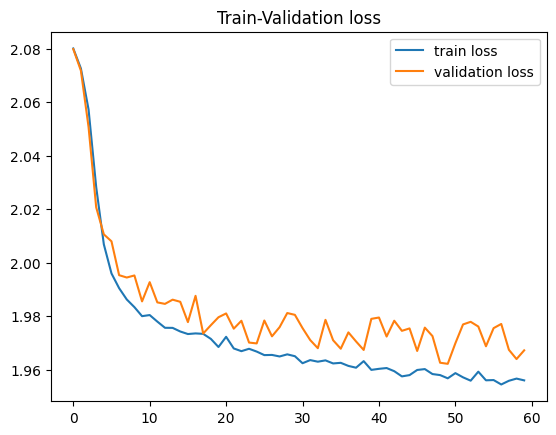

In [14]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path)

In [15]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))

print("Accuracy evaluando en todas las etiquetas")
print(train.eval_function_multi(model,dl_eval,tasks))
print("Accuracy evaluando en etiquetas female")
print(train.eval_function_multi(model,dl_eval,tasks,'female'))
print("Accuracy evaluando en etiquetas male")
print(train.eval_function_multi(model,dl_eval,tasks,'male'))

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Accuracy evaluando en todas las etiquetas
{'to': 0.6691919191919192, 'as': 0.7105606258148631, 'about': 0.8405612244897959}
Accuracy evaluando en etiquetas female
{'to': 0.6535433070866141, 'as': 0.7547169811320755, 'about': 0.8525}
Accuracy evaluando en etiquetas male
{'to': 0.683698296836983, 'as': 0.6691919191919192, 'about': 0.828125}
